In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import elephant
import quantities as pq
import neo
import sys
plt.rcParams['figure.figsize'] = (14, 10)
import scipy.stats as stats
import itertools
import random

# Kullback-Leibler divergence

We want to examine the Kullback-Leilber divergence for comparing distributions. In this notebook we assume the distributions are continuous and not discrete. The divergence is calculated by approxmating a empirical cdf for the two distributions.

In [2]:
def ecdf(x,tot_min,tot_max):
    x = np.sort(list(x)+[tot_min,tot_max])
    u, c = np.unique(x, return_counts=True)
    n = len(x)
    y = (np.cumsum(c) - 0.5)/n
    def interpolate_(x_):
        yinterp = np.interp(x_, u, y, left=tot_min, right=tot_max)
        return yinterp
    return interpolate_

def cumulative_kl(x,y,fraction=0.5): 
    dx = np.diff(np.sort(np.unique(x)))
    dy = np.diff(np.sort(np.unique(y)))
    ex = np.min(dx)
    ey = np.min(dy)
    e = np.min([ex,ey])*fraction
    n = len(x)
    # total max
    max_x = max(x)
    max_y = max(y)
    tot_max = max(max_x,max_y)
    # total min
    min_x = min(x)
    min_y = min(y)
    tot_min = min(min_x, min_y)
    # send tot_max and tot_min to interpolation limits
    P = ecdf(x,tot_min,tot_max)
    Q = ecdf(y,tot_min,tot_max)
    
    # machine epsilon
    machine_eps = np.finfo('float').eps
    summ = 0
    for i in range(0,len(x)):
        if(abs(Q(x[i])-Q(x[i]-e))>3*machine_eps):
            summ += np.log((P(x[i]) - P(x[i]-e))/(Q(x[i]) - Q(x[i]-e)))
    # 1/n*summ - 1 converges to KL divergence    
    KL = (1./n)*summ - 1
    #KL = (1./n)*np.sum(np.log((P(x) - P(x-e))/(Q(x) - Q(x-e)))) - 1
    return KL

We get nan because the expression (P(x)-P(x-e))/(Q(x)-Q(x-e)) is not a real number. Must be division by 0. 

Checked for several of the values that got nan. Seems like we get 0/0. This means that P(x) and P(x-e) are the same. And Q(x) and Q(x-e) are the same. Seems like maybe we need to take bigger steps? To make sure we get different values? Or should i make the function not calculate the KL value for when Q(x) and Q(x-e) are equal? Changing the fraction does not help. That is equivalent to changing step size. Probably best to just avoid calculating KL when x and x-e gives same value for the distributions. Use an if-test.

In [3]:
# mock data
# create 10 normal distributions with 10 000 numbers, mean 0 and standard deviation 1
x = np.random.normal(0, 1, size=(10,10000))

In [4]:
divs_cont = []
for i in range(0,10):
        for j in range(0,i):
            kl = cumulative_kl(x[i],x[j],fraction=0.05)
            divs_cont.append(kl)

In [5]:
print('maximum divergence: ', max(divs_cont), ' minimum divergence: ',min(divs_cont))

maximum divergence:  0.026850628445515223  minimum divergence:  -0.017251327857875864


Try to run for our model.

In [3]:
cv_path = 'C:\\Users\\Nida\\Documents\\NMBU\\master\\spike_data\\CV_distributions\\resolution_1_8'
round_1_2_exc = pd.read_csv(r'{}/brunel_round_1_2_exc_cv.csv'.format(cv_path),index_col=0)
round_1_2_inh = pd.read_csv(r'{}/brunel_round_1_2_inh_cv.csv'.format(cv_path),index_col=0)
exact_1_2_exc = pd.read_csv(r'{}/brunel_exact_1_2_exc_cv.csv'.format(cv_path),index_col=0)
exact_1_2_inh = pd.read_csv(r'{}/brunel_exact_1_2_inh_cv.csv'.format(cv_path),index_col=0)
round_equal_exc = pd.read_csv(r'{}/brunel_round_equal_exc_cv.csv'.format(cv_path),index_col=0)
round_equal_inh = pd.read_csv(r'{}/brunel_round_equal_inh_cv.csv'.format(cv_path),index_col=0)
exact_equal_exc = pd.read_csv(r'{}/brunel_exact_equal_exc_cv.csv'.format(cv_path),index_col=0)
exact_equal_inh = pd.read_csv(r'{}/brunel_exact_equal_inh_cv.csv'.format(cv_path),index_col=0)
continuous_exc = pd.read_csv(r'{}/brunel_continuous_exc_cv.csv'.format(cv_path),index_col=0)
continuous_inh = pd.read_csv(r'{}/brunel_continuous_inh_cv.csv'.format(cv_path),index_col=0)

In [4]:
def kl(cv_list_exc,cv_list_inh):
    cv_list_exc = cv_list_exc.values.tolist()
    cv_list_inh = cv_list_inh.values.tolist()
    divs_exc = []
    divs_inh = []
    for i in range(0,10):
        for j in range(0,i):
            kl_exc = cumulative_kl(cv_list_exc[i],cv_list_exc[j],fraction=0.05)
            kl_inh = cumulative_kl(cv_list_inh[i],cv_list_inh[j],fraction=0.05)
            divs_exc.append(kl_exc)
            divs_inh.append(kl_inh)
    return divs_exc, divs_inh

In [5]:
divs_exc_round_1_2_self, divs_inh_round_1_2_self = kl(round_1_2_exc, round_1_2_inh)

In [60]:
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.018555506341647376  minimum divergence:  -0.022423143878084306
maximum divergence:  0.05101233279345463  minimum divergence:  -0.04169866833513369


In [19]:
divs_exc_exact_1_2_self, divs_inh_exact_1_2_self = kl(exact_1_2_exc, exact_1_2_inh)

In [62]:
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.027617736375079138  minimum divergence:  -0.024542611683108007
maximum divergence:  0.039348383632115125  minimum divergence:  -0.04916936958762064


In [63]:
divs_exc, divs_inh = kl(round_equal_exc, round_equal_inh)

In [64]:
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.035136333050083124  minimum divergence:  -0.011492371515357203
maximum divergence:  0.09350879776204324  minimum divergence:  -0.04978267501807632


In [65]:
divs_exc, divs_inh = kl(exact_equal_exc, exact_equal_inh)

In [66]:
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.03428111906212283  minimum divergence:  -0.030421123313659093
maximum divergence:  0.0293579996755593  minimum divergence:  -0.04832179965643424


In [25]:
divs_exc_cont_self, divs_inh_cont_self = kl(continuous_exc, continuous_inh)

In [68]:
print('maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

maximum divergence:  0.02315216986106705  minimum divergence:  -0.026458550789427604
maximum divergence:  0.05468341051206704  minimum divergence:  -0.05243706941853943


Get KL divergence for pairs of simulations from two different models. Rounded brunel 1 2 vs. exact brunel 1 2.

In [71]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.05542959347769538  minimum divergence:  0.001089517671710949
inhibitory. maximum divergence:  0.13581240868103128  minimum divergence:  -0.032578253981871974


In [73]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.02783868647965715  minimum divergence:  -0.02929957373628367
inhibitory. maximum divergence:  0.07328846100630448  minimum divergence:  -0.04468788001222612


In [77]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.048667733453735096  minimum divergence:  -0.00963277045878086
inhibitory. maximum divergence:  0.07948794617256927  minimum divergence:  -0.04729793731454279


In [8]:
def kl_two(value_list_1,value_list_2):
    value_list_1 = value_list_1.values.tolist()
    value_list_2 = value_list_2.values.tolist()
    comb = list(itertools.product(value_list_1, value_list_2))
    kls = []
    for i in range(0,len(comb)):
        kl = cumulative_kl(comb[i][0],comb[i][1],fraction=0.05)
        kls.append(kl)
    return kls

In [20]:
divs_exc_round_exact = kl_two(round_1_2_exc, exact_1_2_exc)
divs_inh_round_exact = kl_two(round_1_2_inh, exact_1_2_inh)

In [10]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.055429626203565174  minimum divergence:  0.001089580537390944
inhibitory. maximum divergence:  0.13581239720787086  minimum divergence:  -0.03257825313636731


rounded 1 2 vs rounded equal.

In [21]:
divs_exc_round_equal = kl_two(round_1_2_exc,round_equal_exc)
divs_inh_round_equal = kl_two(round_1_2_inh, round_equal_inh)

In [12]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.027838675382482858  minimum divergence:  -0.029310512414981504
inhibitory. maximum divergence:  0.07328854491264036  minimum divergence:  -0.04468787960960341


rounded 1 2 vs. exact equal

In [22]:
divs_exc_round_exact = kl_two(round_1_2_exc,exact_equal_exc)
divs_inh_round_exact = kl_two(round_1_2_inh, exact_equal_inh)

In [14]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04862744717550305  minimum divergence:  -0.009632724295461359
inhibitory. maximum divergence:  0.07948794796996728  minimum divergence:  -0.04729793648958158


rounded 1 2 vs continuous.

In [23]:
divs_exc_round_continuous = kl_two(round_1_2_exc,continuous_exc)
divs_inh_round_continuous = kl_two(round_1_2_inh, continuous_inh)

In [16]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.047708838079617344  minimum divergence:  -0.008401297397597762
inhibitory. maximum divergence:  0.0913076645150861  minimum divergence:  -0.026165946959320174


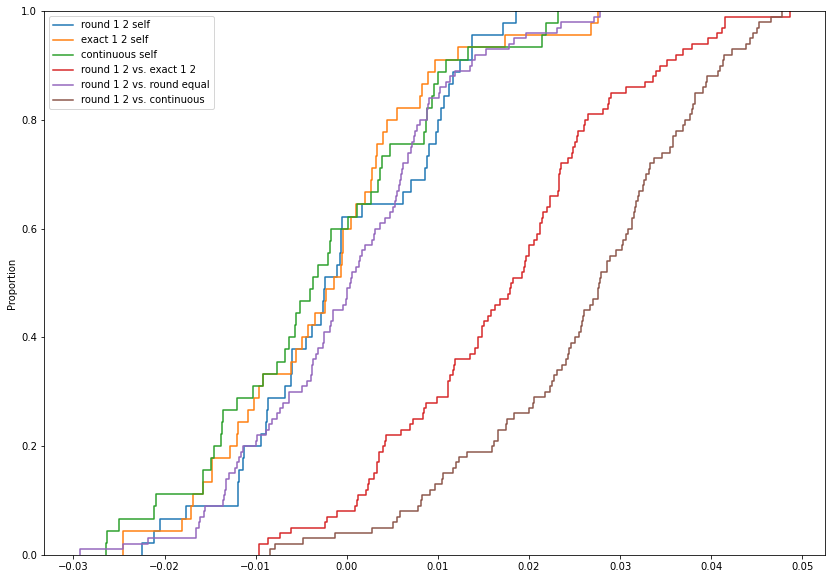

In [26]:
sns.ecdfplot(divs_exc_round_1_2_self,label='round 1 2 self')
sns.ecdfplot(divs_exc_exact_1_2_self, label='exact 1 2 self')
sns.ecdfplot(divs_exc_cont_self, label='continuous self')
sns.ecdfplot(divs_exc_round_exact, label='round 1 2 vs. exact 1 2')
sns.ecdfplot(divs_exc_round_equal,label='round 1 2 vs. round equal')
sns.ecdfplot(divs_exc_round_continuous,label='round 1 2 vs. continuous')
plt.legend();

exact 1 2 vs. rounded equal.

In [17]:
divs_exc = kl_two(exact_1_2_exc,round_equal_exc)
divs_inh = kl_two(exact_1_2_inh, round_equal_inh)

In [79]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.06342853074665222  minimum divergence:  -0.00497379978853929
inhibitory. maximum divergence:  0.09446769031140034  minimum divergence:  -0.03397371197705701


exact 1 2 vs. exact equal.

In [80]:
divs_exc = kl_two(exact_1_2_exc,exact_equal_exc)
divs_inh = kl_two(exact_1_2_inh, exact_equal_inh)

In [81]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.024990443898313952  minimum divergence:  -0.042222346007015354
inhibitory. maximum divergence:  0.04947228537148307  minimum divergence:  -0.04902635935482813


exact 1 2 vs. continuous.

In [82]:
divs_exc = kl_two(exact_1_2_exc,continuous_exc)
divs_inh = kl_two(exact_1_2_inh, continuous_inh)

In [83]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.016571461087499184  minimum divergence:  -0.03300213070521785
inhibitory. maximum divergence:  0.04803179629839871  minimum divergence:  -0.0581683840054491


rounded equal vs. exact equal.

In [84]:
divs_exc = kl_two(round_equal_exc,exact_equal_exc)
divs_inh = kl_two(round_equal_inh, exact_equal_inh)

In [85]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.06232302284675639  minimum divergence:  -0.008841152235647631
inhibitory. maximum divergence:  0.09377735145115307  minimum divergence:  -0.04345021609011346


rounded equal vs. continuous.

In [86]:
divs_exc = kl_two(round_equal_exc,continuous_exc)
divs_inh = kl_two(round_equal_inh, continuous_inh)

In [87]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.07606477215532026  minimum divergence:  -0.0009505652264649722
inhibitory. maximum divergence:  0.10531530477939932  minimum divergence:  -0.027475318126247927


exact equal vs. continouous.

In [88]:
divs_exc = kl_two(exact_equal_exc,continuous_exc)
divs_inh = kl_two(exact_equal_inh, continuous_inh)

In [89]:
print('excitatory. maximum divergence: ',max(divs_exc), ' minimum divergence: ',min(divs_exc))
print('inhibitory. maximum divergence: ',max(divs_inh), ' minimum divergence: ',min(divs_inh))

excitatory. maximum divergence:  0.04207255921369746  minimum divergence:  -0.035250438687493
inhibitory. maximum divergence:  0.04607618337822994  minimum divergence:  -0.0623931037221549
